This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        5
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        4
        inequality constraints with only lower bounds:        2
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        2

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.03e+03 5.00e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

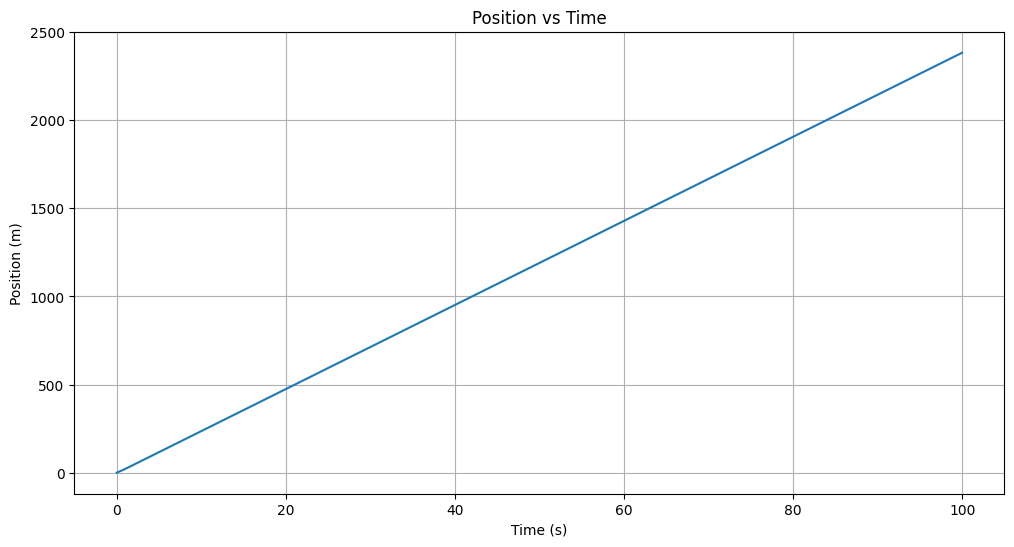

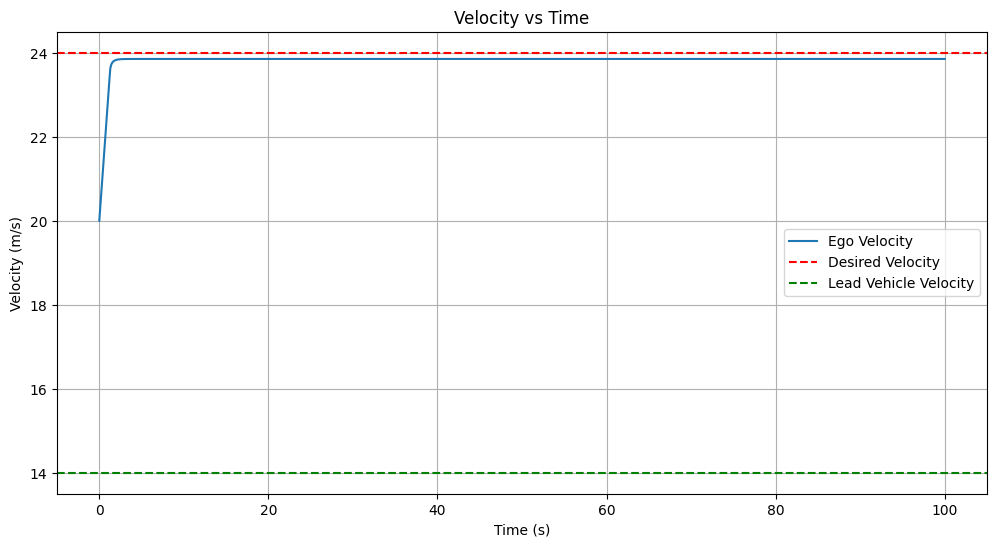

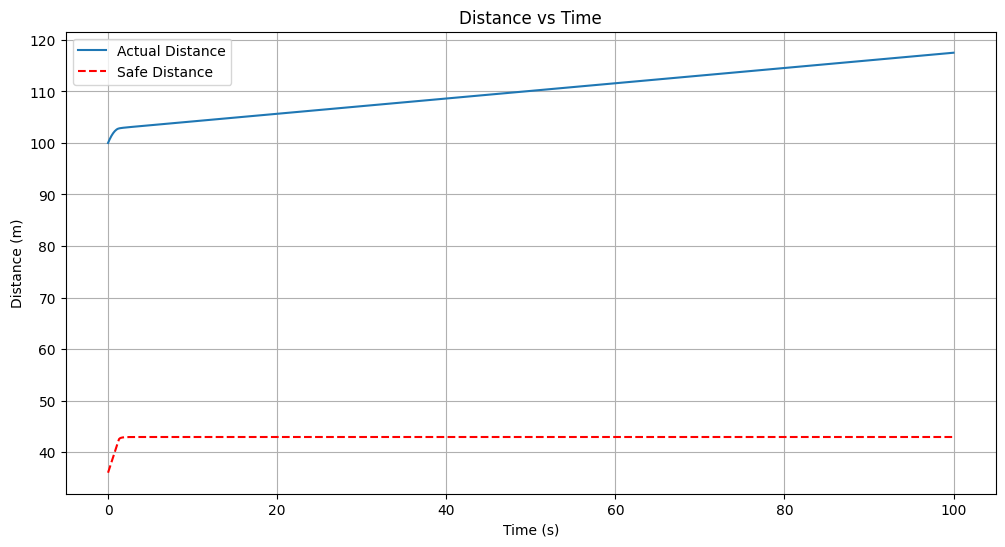

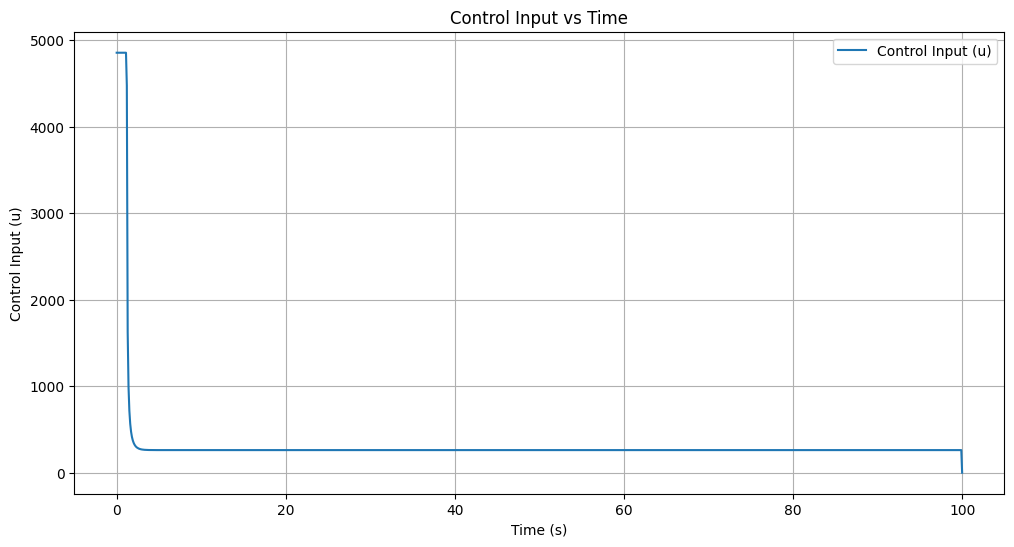

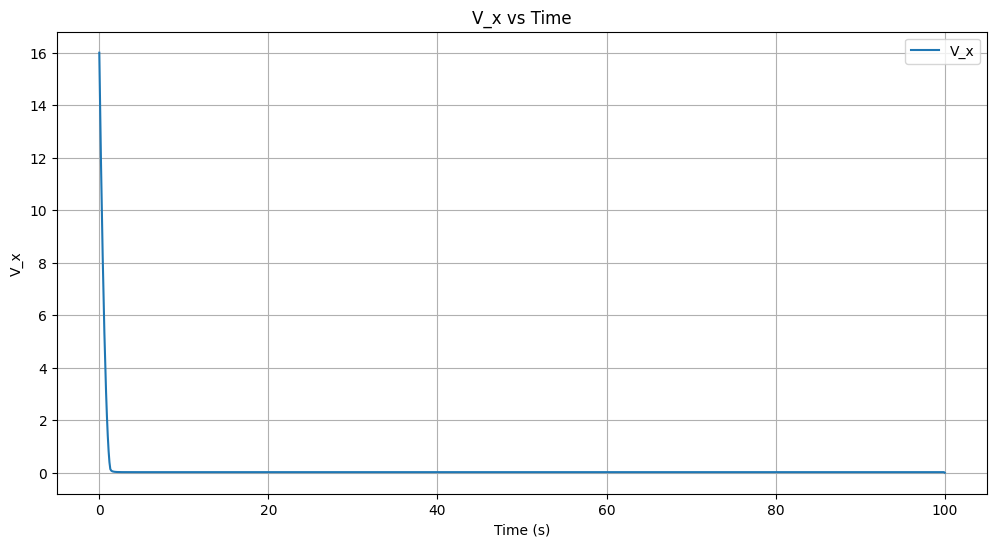

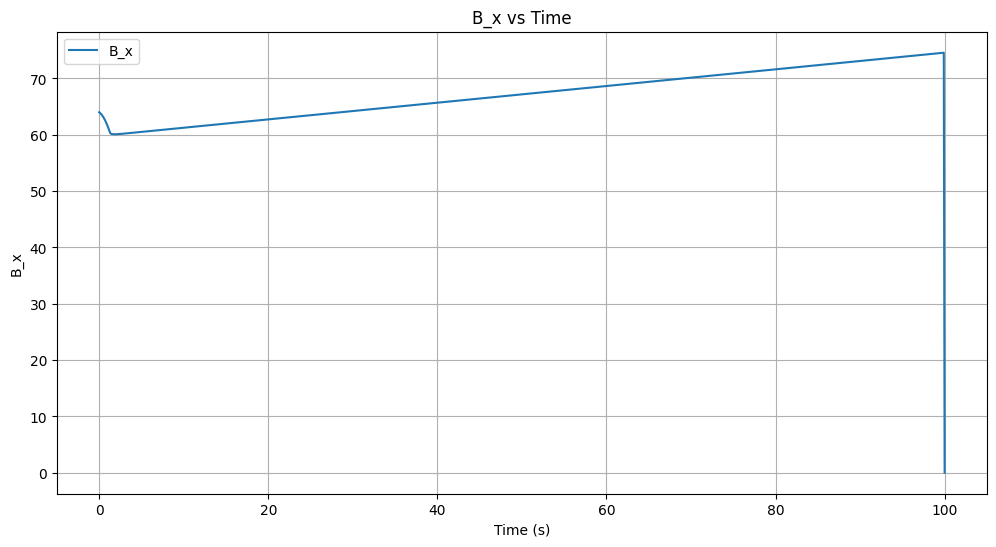

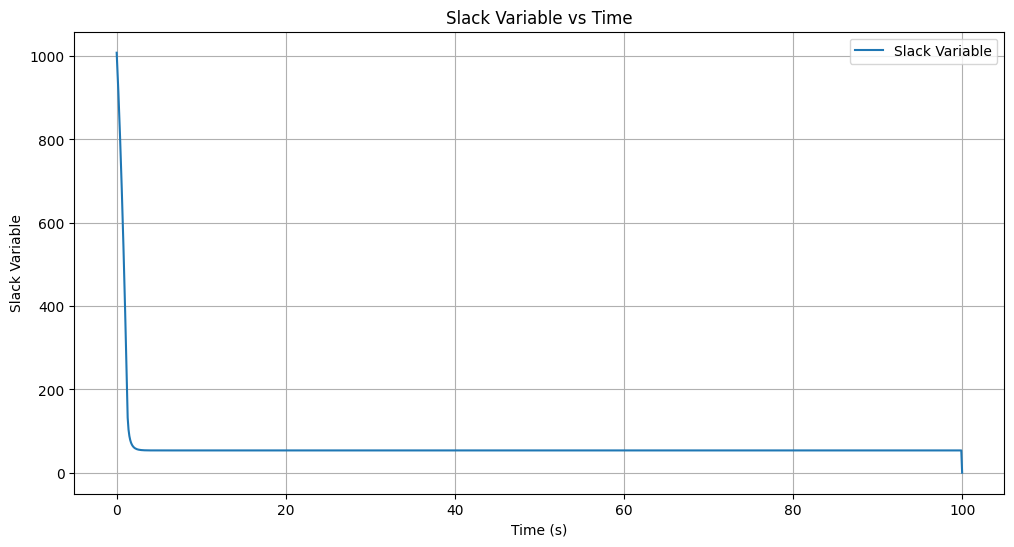

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from acc import ACC, Controller

params = {
    "m": 1650,
    "g": 9.81,
    "v_d": 24,
    "f_0": 0.1,
    "f_1": 5,
    "f_2": 0.25,
    "T_h": 1.8,
    "v_0": 14,
    "c_d": 0.3,
    "c_a": 0.3,
    "clf_rate": 5,
    "cbf_rate": 5,
    "input_weight": 2 / 1650**2,
    "slack_weight": 2e-2,  # slack variable权重
}

# 初始状态 [p, v, z]
x0 = np.array([0, 20, 100])
t_eval = np.linspace(0, 100, 1000)
dt = t_eval[1] - t_eval[0]  # 时间步长0.1秒

# 初始化状态历史和控制输入
x_hist = np.zeros((len(t_eval), len(x0)))
x_hist[0, :] = x0
u_hist = np.zeros_like(t_eval).reshape(-1, 1)
V_hist = np.zeros_like(t_eval).reshape(-1, 1)
B_hist = np.zeros_like(t_eval).reshape(-1, 1)
slack_hist = np.zeros_like(t_eval).reshape(-1, 1)


# 创建ACC系统实例
acc = ACC(x0, **params)
controller = Controller(**params)

def dynamics(t, x, u_val):
    """包装动力学计算函数"""
    return acc.dynamics(t, x, u_val).flatten()

# RK4单步仿真循环
for i in range(len(t_eval)-1):
    t = t_eval[i]
    x_current = x_hist[i, :]
    
    u_hist[i], V_hist[i], B_hist[i], slack_hist[i] = controller.nlp_solve(t, x_current, [0])  # 计算控制输入
    
    u_current = u_hist[i]  # 当前时间步控制输入
    
    # 计算四个斜率
    k1 = dt * dynamics(t, x_current, u_current)
    k2 = dt * dynamics(t + dt/2, x_current + k1/2, u_current)
    k3 = dt * dynamics(t + dt/2, x_current + k2/2, u_current)
    k4 = dt * dynamics(t + dt, x_current + k3, u_current)
    
    # 更新状态
    x_next = x_current + (k1 + 2*k2 + 2*k3 + k4)/6
    x_hist[i+1, :] = x_next
    
    print(f"Step {i+1}/{len(t_eval)-1}, Time: {t:.2f}s, State: {x_next}, Control Input: {u_current}")

# 可视化结果（单独绘制每张图）
plt.figure(figsize=(12, 6))
plt.plot(t_eval, x_hist[:, 0])
plt.title('Position vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(t_eval, x_hist[:, 1], label='Ego Velocity')
plt.axhline(params["v_d"], color='r', linestyle='--', label='Desired Velocity')
plt.axhline(params["v_0"], color='g', linestyle='--', label='Lead Vehicle Velocity')
plt.title('Velocity vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
safe_distance = params["T_h"] * x_hist[:, 1]
plt.plot(t_eval, x_hist[:, 2], label='Actual Distance')
plt.plot(t_eval, safe_distance, '--r', label='Safe Distance')
plt.title('Distance vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Distance (m)')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(t_eval, u_hist, label='Control Input (u)')
plt.title('Control Input vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Control Input (u)')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(t_eval, V_hist, label='V_x')
plt.title('V_x vs Time')
plt.xlabel('Time (s)')
plt.ylabel('V_x')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(t_eval, B_hist, label='B_x')
plt.title('B_x vs Time')
plt.xlabel('Time (s)')
plt.ylabel('B_x')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(t_eval, slack_hist, label='Slack Variable')
plt.title('Slack Variable vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Slack Variable')
plt.legend()
plt.grid()
plt.show()
